# DSCI 100 Project

In [25]:
library(tidyverse)
library(repr)
library(tidymodels)
library(rvest)
library(janitor)
options(repr.matrix.max.rows = 6)


Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding




# Introduction

## Background Information

As digital platforms continue to expand their impact to connect people with similar interests and characteristics, it becomes important for tailored information to reach those in need. In this project, I explore the relationship between unique features of MineCraft players and their subscription to gaming-related newspapers. Results of this investigation will be valuable for organizations looking to spread game-related content, since it will identify their core target audience and maximize the influence of their information. 

## Question

Can subscription to game-related newspaper be predicted by gender, hour of play, and experience in the players dataset? 

## Data Description

To answer this question we will analyze a dataset of MineCraft player data. The data was collected by the Department of Computer Science at UBC, led by Frank Wood. Each row in the data set contains information of a unique player, with 196 observations present. 

There are 7 columns in the dataset:

- `Experience` - The skill tier
- `subscribe` - Subscription to a gaming-related newplayer
- `hashedEmail` - Email address converted to chr
- `played_hours` - The total gaming time
- `name` of the player
- `gender` of the player	
- `Age` of the player

An immediate problem I can see in the .csv file is that the column names are not clean; some columns are capitalized, such as `Experience`, while others are not, such as `subscribe`. In addition, one variable with more than one word is in camel case (`hashedEmail`) while the other is in snake case (`played_hours`). 


After loading the data, I can see that many variables are not in the correct type. For example, the `Experience` variable in the the `chr` format, when it makes more sense to the `fct` type. 


After a first look at the dataset, I also think some variables may not be of much use. In particular, I do not think `hashedEmail` and `name` are relevant in making the prediction regarding subscription. 

# Methods

First, the file containing players data is read into an object called `player_data`. Irrelevant information, specifically email and name, are omitted, and the variable names are tidied into conventional format. 

In [33]:
url <- "https://raw.githubusercontent.com/Elauri/dsci-100-project/refs/heads/main/players.csv"
player_data <- read_csv(url) |>
    select(-hashedEmail, -name) |>
    clean_names()
player_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,played_hours,gender,age
<chr>,<lgl>,<dbl>,<chr>,<dbl>
Pro,TRUE,30.3,Male,9
Veteran,TRUE,3.8,Male,17
Veteran,FALSE,0.0,Male,17
⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,0.0,Prefer not to say,17
Amateur,FALSE,2.3,Male,17
Pro,TRUE,0.2,Other,NA


I would like to investigate whether a player subscribing to a gaming newsletter may be predicted by play time and age.

We can first observe the trend through graphs.

In [6]:
player_data <- player_data |>
                    mutate(experience = factor(experience, 
                                               levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran")))
player_data

experience,subscribe,played_hours,gender,age
<fct>,<lgl>,<dbl>,<chr>,<dbl>
Pro,TRUE,30.3,Male,9
Veteran,TRUE,3.8,Male,17
Veteran,FALSE,0.0,Male,17
⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,0.0,Prefer not to say,17
Amateur,FALSE,2.3,Male,17
Pro,TRUE,0.2,Other,NA


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


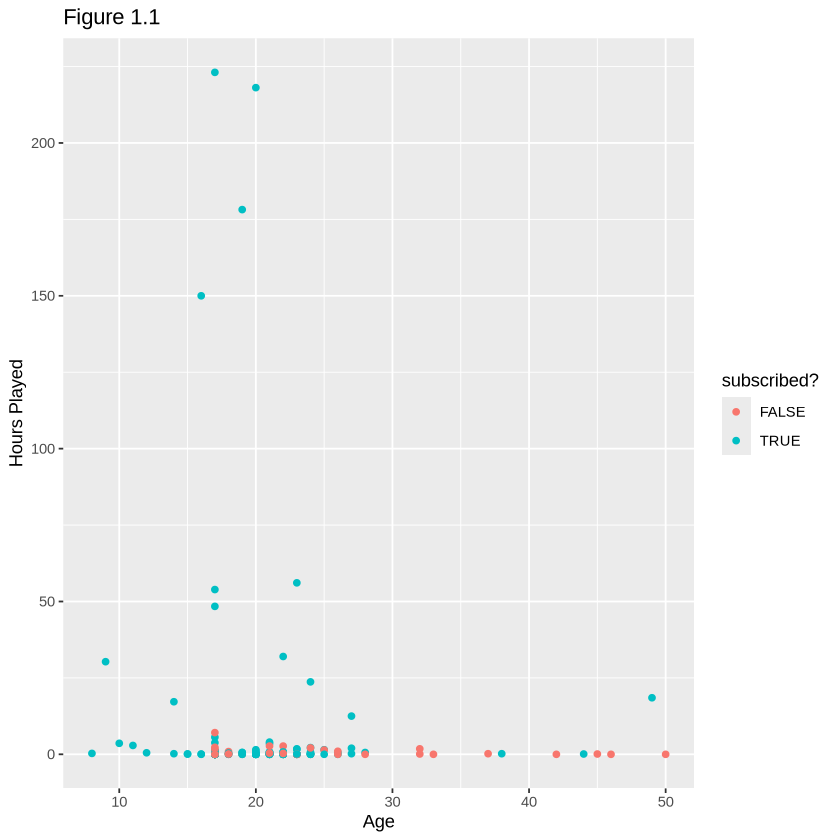

In [8]:
time_age_plot <- player_data |>
                ggplot(aes(x = age, y = played_hours)) +
                geom_point(aes(color = subscribe)) +
                labs(x = "Age", y = "Hours Played", color = "subscribed?") +
                ggtitle("Figure 1.1")
time_age_plot

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


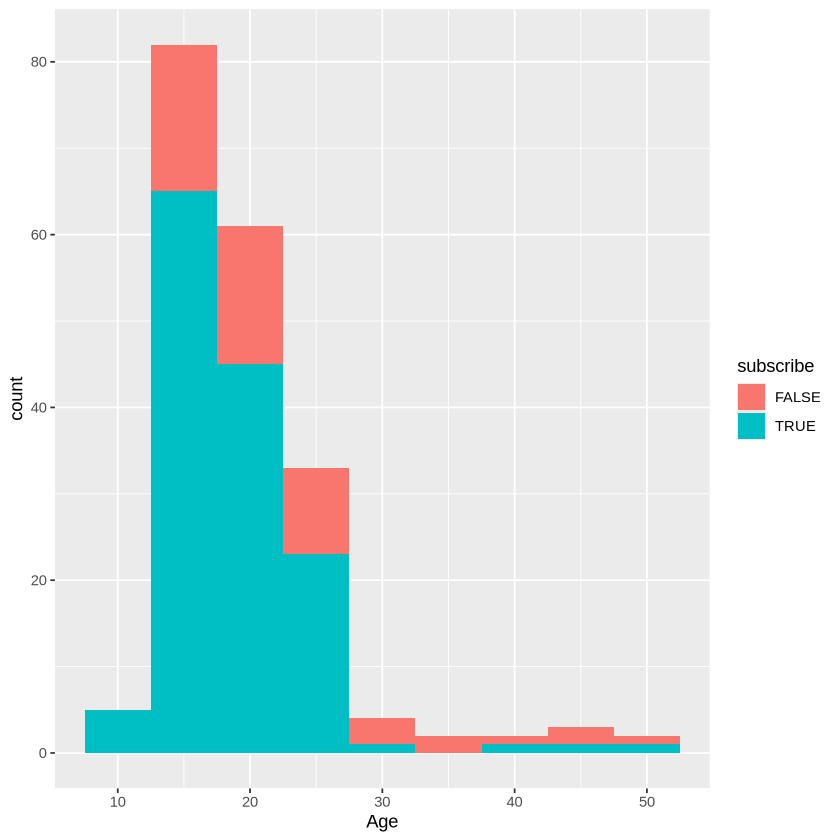

In [70]:
age_histogram <- ggplot(player_data, aes(x = Age)) +
                geom_histogram(binwidth = 5, aes(fill = subscribe))
age_histogram

In [49]:
avg_time_sub <- player_data |>
                filter(Age == 17) |>
                group_by(subscribe) |>
                summarize(avg_time_played_hrs = mean(played_hours, na.rm = TRUE))
avg_time_sub

subscribe,avg_time_played_hrs
<lgl>,<dbl>
FALSE,0.700000
TRUE,5.946552


In [ ]:
experience_sub <- player_data |>
                group_by(experience, subscribe) |>
                summarize(count = n()) |>
                mutate(total_num = nrow(player_data)) |>
                mutate(percentage = count / total_num) |>
                select(experience, subscribe, percentage)
experience_sub

In [50]:
experience_sub_17 <- player_data |>
                    filter(Age == 17) |>
                    group_by(experience, subscribe) |>
                    summarize(count = n()) |>
                    mutate(total_num = nrow(player_data)) |>
                    mutate(percentage = count / total_num) |>
                    select(experience, subscribe, percentage)
experience_sub_17

`summarise()` has grouped output by 'experience'. You can override using the
`.groups` argument.


experience,subscribe,percentage
<fct>,<lgl>,<dbl>
Beginner,FALSE,0.01530612
Beginner,TRUE,0.07142857
Amateur,FALSE,0.03061224
⋮,⋮,⋮
Pro,TRUE,0.02040816
Veteran,FALSE,0.01530612
Veteran,TRUE,0.07142857


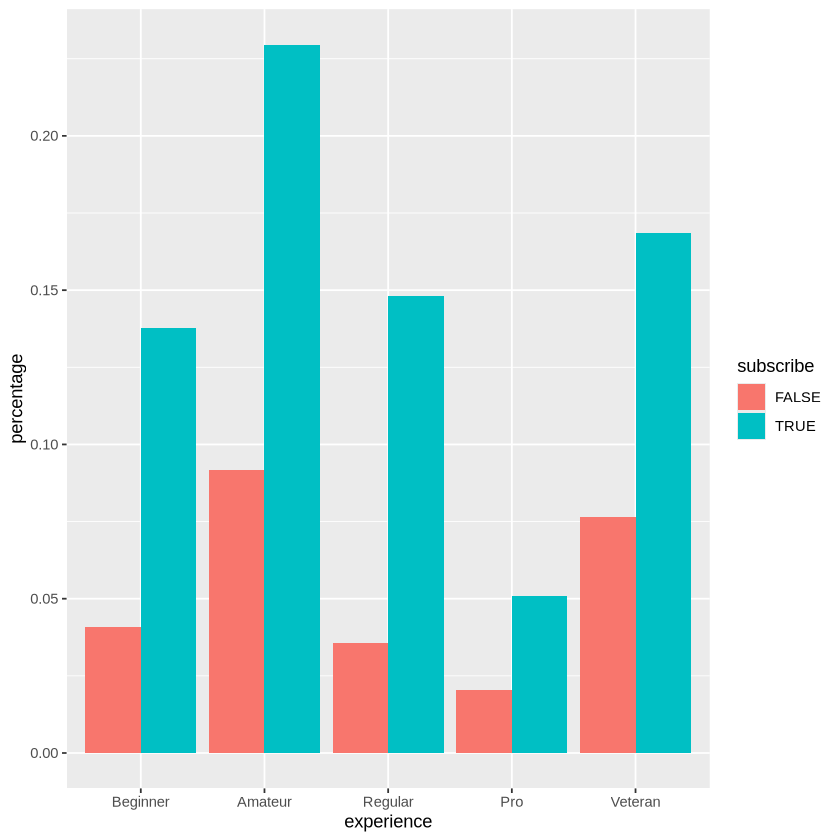

In [51]:
experience_sub_graph <- ggplot(experience_sub, aes(x = experience, y = percentage)) +
                        geom_bar(stat = "identity", position = "dodge", aes(fill = subscribe))
experience_sub_graph

In [52]:
subscribe_count = player_data |>
                filter(Age == 17) |>
                group_by(subscribe) |>
                summarize(count = n())
subscribe_count

subscribe,count
<lgl>,<int>
FALSE,17
TRUE,58


In [54]:
age_sub <- player_data |>
        filter(Age == 17) |>
        group_by(gender, subscribe) |>
        summarize(count = n()) |>
        arrange(desc(count)) |>
        mutate(total_players = nrow(player_data)) |>
        mutate(percentage = count / total_players) |>
        select(gender, subscribe, percentage)
age_sub

`summarise()` has grouped output by 'gender'. You can override using the
`.groups` argument.


gender,subscribe,percentage
<chr>,<lgl>,<dbl>
Male,TRUE,0.17857143
Female,TRUE,0.06122449
Male,FALSE,0.04081633
⋮,⋮,⋮
Prefer not to say,FALSE,0.01530612
Two-Spirited,TRUE,0.01530612
Prefer not to say,TRUE,0.01020408


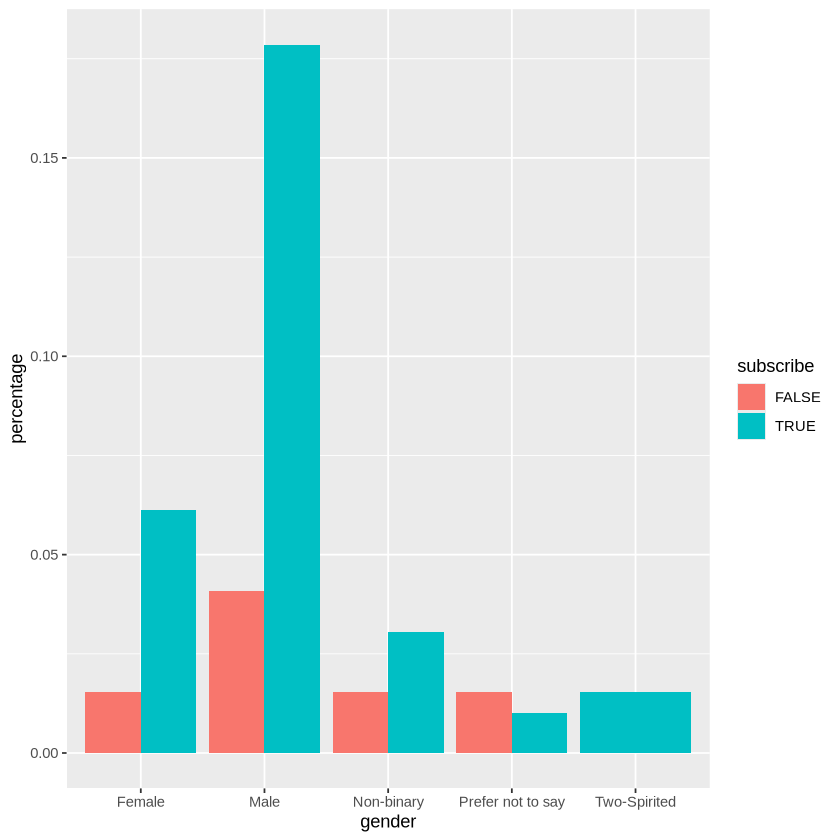

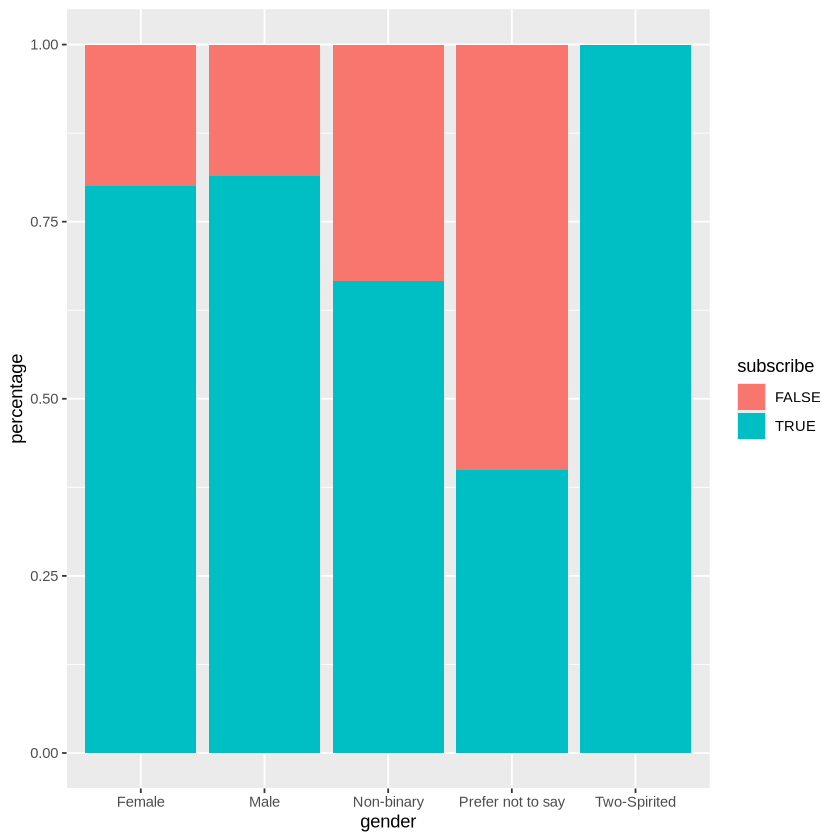

In [69]:
age_sub_plot <- ggplot(age_sub, aes(x = gender, y = percentage))
age_sub_plot_1 <- age_sub_plot + geom_bar(stat = "identity", position = "dodge", aes(fill = subscribe))
age_sub_plot_1
age_sub_plot_2 <- age_sub_plot + geom_bar(stat = "identity", position = "fill", aes(fill = subscribe))
age_sub_plot_2 

# Predictive Model

## Finding the Best K value

In [62]:
players_processed <- player_data |>
                    filter(Age > 15, Age < 25) |>
                    select(experience, subscribe, played_hours, gender) |>
                    mutate(subscribe = as_factor(subscribe))
players_processed

experience,subscribe,played_hours,gender
<fct>,<fct>,<dbl>,<chr>
Veteran,TRUE,3.8,Male
Veteran,FALSE,0.0,Male
Amateur,TRUE,0.7,Female
⋮,⋮,⋮,⋮
Veteran,FALSE,0.3,Male
Amateur,FALSE,0.0,Prefer not to say
Amateur,FALSE,2.3,Male


In [63]:
set.seed(1000)
players_split <- initial_split(players_processed, prop = 0.70, strata = subscribe)
players_training <- training(players_split)
players_testing <- testing(players_split)

In [64]:
set.seed(2000)
sub_recipe <- recipe(subscribe ~ played_hours + experience + gender, data = players_training) |>
            step_scale(played_hours) |>
            step_center(played_hours)
sub_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")
sub_vfold <- vfold_cv(players_training, v = 5, strata = subscribe)
vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

sub_fit <- workflow() |>
        add_recipe(sub_recipe) |>
        add_model(sub_spec) |>
        tune_grid(resamples = sub_vfold, grid = vals) |>
        collect_metrics() |>
        filter(.metric == "accuracy") |>
        filter(mean == max(mean))
sub_fit

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 22 rows.
               ✖ Assigned data has 23 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 23 to size 22.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,binary,0.7341897,4,0.02846239,Preprocessor1_Model09
10,accuracy,binary,0.7341897,4,0.02846239,Preprocessor1_Model10


In [65]:
set.seed(3000)
tuned_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
            set_engine("kknn") |>
            set_mode("classification")
tuned_fit <- workflow() |>
            add_recipe(sub_recipe) |>
            add_model(tuned_spec) |>
            fit(players_training)

In [66]:
set.seed(4000)
players_predictions <- predict(tuned_fit, players_testing) |>
                    bind_cols(players_testing)
players_predictions
players_metrics <- players_predictions |>
                metrics(truth = subscribe, estimate = .pred_class)
players_metrics
players_conf_mat <- players_predictions |>
                    conf_mat(truth = subscribe, estimate = .pred_class)
players_conf_mat

.pred_class,experience,subscribe,played_hours,gender
<fct>,<fct>,<fct>,<dbl>,<chr>
TRUE,Veteran,FALSE,0.0,Male
TRUE,Amateur,TRUE,0.7,Female
TRUE,Regular,TRUE,0.0,Female
⋮,⋮,⋮,⋮,⋮
TRUE,Beginner,TRUE,0.0,Female
TRUE,Veteran,FALSE,0.3,Male
TRUE,Amateur,FALSE,2.3,Male


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7551020
kap,binary,0.1453488


          Truth
Prediction FALSE TRUE
     FALSE     2    2
     TRUE     10   35

$Recall = 35 / 37 = 0.95$

$Precision = 35 / 45 = 0.78$